# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [2]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [3]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [4]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Xval = Xval.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape,train_set[0].shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1) (50000, 784)


In [5]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


In [6]:
len(np.unique(Ttrain))

10

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


adam: Epoch 2 Loss 0.422
adam: Epoch 4 Loss 0.271
adam: Epoch 6 Loss 0.225
adam: Epoch 8 Loss 0.203
adam: Epoch 10 Loss 0.195
adam: Epoch 12 Loss 0.183
adam: Epoch 14 Loss 0.175
adam: Epoch 16 Loss 0.176
adam: Epoch 18 Loss 0.162
adam: Epoch 20 Loss 0.165


Text(0.5, 1.0, 'MNIST')

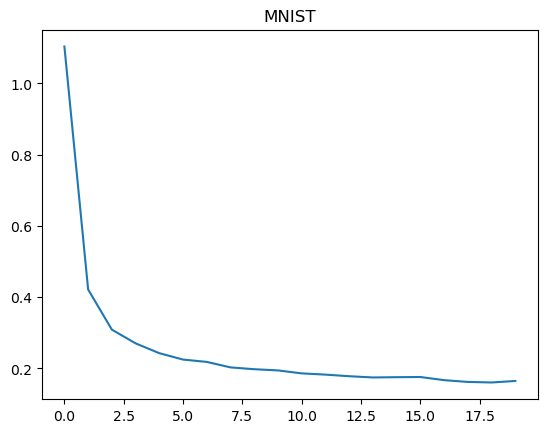

In [7]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet.error_trace = [e.detach().numpy() for e in cnnet.error_trace]
plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [8]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [9]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.16


,0,1,2,3,4,5,6,7,8,9
0,96.938776,0.000000,0.204082,0.204082,0.204082,0.000000,0.714286,0.714286,0.816327,0.204082
1,0.000000,97.180617,0.440529,0.088106,0.176211,0.528634,0.352423,0.000000,1.233480,0.000000
2,1.162791,0.484496,94.089147,1.550388,0.193798,0.096899,0.290698,0.678295,1.356589,0.096899
3,0.000000,0.000000,1.584158,93.564356,0.000000,1.089109,0.297030,0.693069,2.376238,0.396040
4,0.712831,0.407332,0.000000,0.000000,95.213849,0.203666,1.018330,0.305499,0.203666,1.934827
5,0.448430,0.112108,0.336323,2.242152,0.784753,93.273543,1.008969,0.112108,0.896861,0.784753
6,1.043841,0.000000,0.730689,0.000000,0.626305,1.983299,95.302714,0.104384,0.000000,0.208768
7,0.583658,0.389105,3.501946,0.875486,0.778210,0.000000,0.291829,90.856031,0.389105,2.334630
8,0.616016,0.000000,1.540041,0.410678,0.718686,2.772074,0.102669,0.513347,92.915811,0.410678
9,0.099108,0.594648,0.000000,0.891972,3.270565,1.387512,0.000000,1.189296,0.594648,91.972250


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [10]:
from IPython.display import display, clear_output  # for the following animation.
import matplotlib.animation as animation
from pdb import set_trace
import time

def run_experiment(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,
                   n_hidden_units_per_layer_choices,patch_size_per_conv_layer_choices,stride_per_conv_layer_choices,
                   n_hiddens_per_fc_layer_choices):
    n_epochs = 20
    batch_size = 500
    learning_rate = 0.01
    results = []
    Classes = np.unique(Ttrain)
    fig = plt.figure(figsize=(8, 8))
    val_graph = []
    #     Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,n_folds)
    #         print(epoch)
    i = 0
    for i in range(len(n_hidden_units_per_layer_choices)):
        Time = []
        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))

        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], hidden_units,len(Classes))
        n_hiddens_per_conv_layer = n_hidden_units_per_layer_choices[i]
        patch_size_per_conv_layer= patch_size_per_conv_layer_choices[i]
        stride_per_conv_layer = stride_per_conv_layer_choices[i]
        n_hiddens_per_fc_layer=n_hiddens_per_fc_layer_choices[i]
#         set_trace()
        cnnet = CNN2D(28 * 28,
                      n_hiddens_per_conv_layer,
                      n_hiddens_per_fc_layer,
                      len(np.unique(Ttrain)),
                      patch_size_per_conv_layer,
                      stride_per_conv_layer,
                      device=device)

        start_time = time.time()

        cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


        Time_for_train = time.time() - start_time
        
        Classes, _ = cnnet.use(Xtest)
        perc_correct = 100 * np.mean(Classes == Ttest)

        C_test, Y_test = cnnet.use(Xtest)
        C_train, Y_train = cnnet.use(Xtrain)
        C_val, Y_val = cnnet.use(Xval)
        
        test_p = 100 * np.mean(C_test == Ttest)
        train_p = 100 * np.mean(C_train == Ttrain)
        val_p = 100 * np.mean(C_val == Tval)
                   
       
        val_graph.append(train_p)
        results.append([n_hiddens_per_conv_layer, train_p, val_p, test_p, Time_for_train])
        df = pandas.DataFrame(results,
                              columns=('nh', 'Train', 'Validate', 'Test',
                                       'Time'))
        fig.clf()

        # In second panel plot the weights versus the epoch number
        # plt.subplot(2, 2, i+1)
        # set_trace()
        xs = range(df.shape[0])
        plt.plot(xs, val_graph, 'o-')

        xticks = df[['nh']].apply(lambda x: f'{x[0]}',
                                  axis=1)  # converting to strings
        plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
        plt.xlabel('Epochs, Architecture')
        plt.xlim(0, len(n_hidden_units_per_layer_choices))
        plt.ylim(90, 100)
        plt.legend(('$Validation$', '$w_1$'))
        clear_output(wait=True)
        display(fig)

    return df

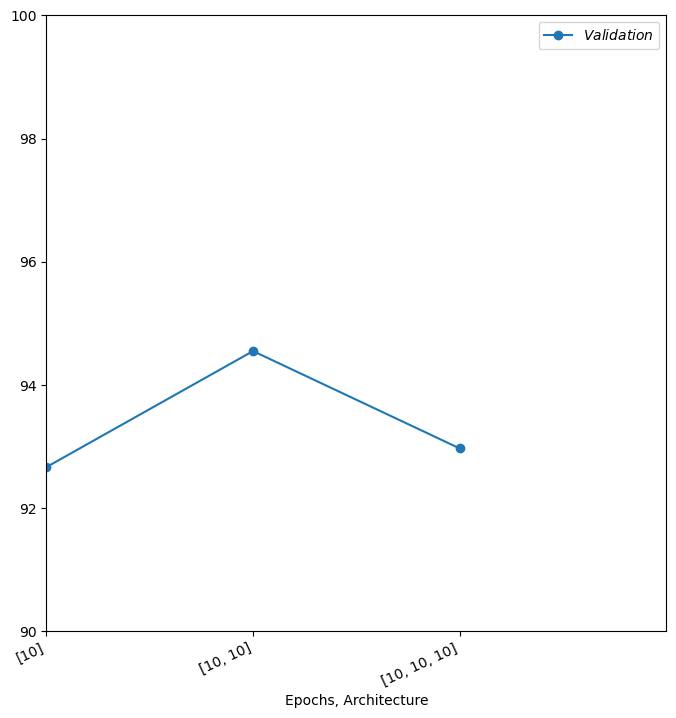

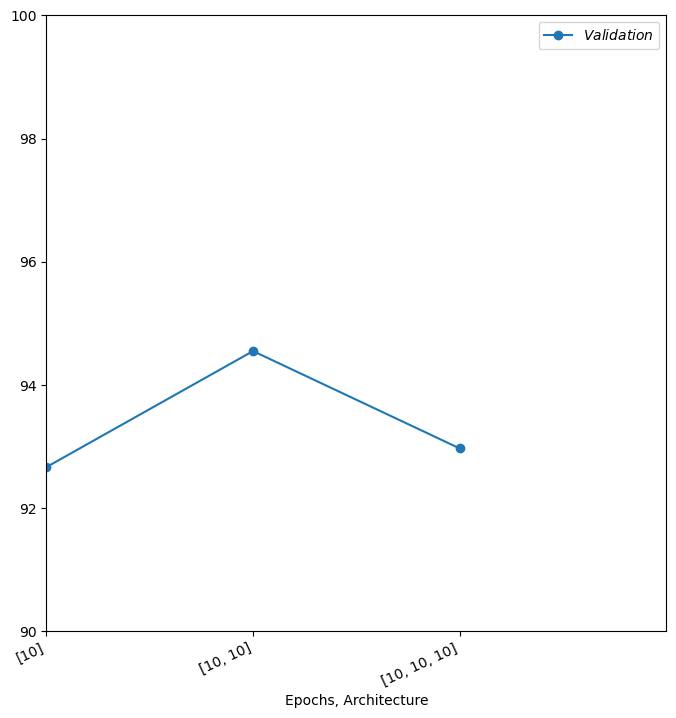

In [11]:
# n_hiddens_per_conv_layer = [10, 10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]


result_df = run_experiment( Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices=[[10],[10,10],[10,10,10]],
                           n_hiddens_per_fc_layer_choices=[[10],[10,10],[10,10,10]],
                          patch_size_per_conv_layer_choices = [[5],[5,5],[4,4,4]],
                          stride_per_conv_layer_choices=[[1],[1,1],[1,1,1]])

In [12]:
result_df

,nh,Train,Validate,Test,Time
0,[10],92.668,92.93,92.46,138.459348
1,"[10, 10]",94.552,94.91,94.30,631.673194
2,"[10, 10, 10]",92.972,93.33,93.46,852.068342


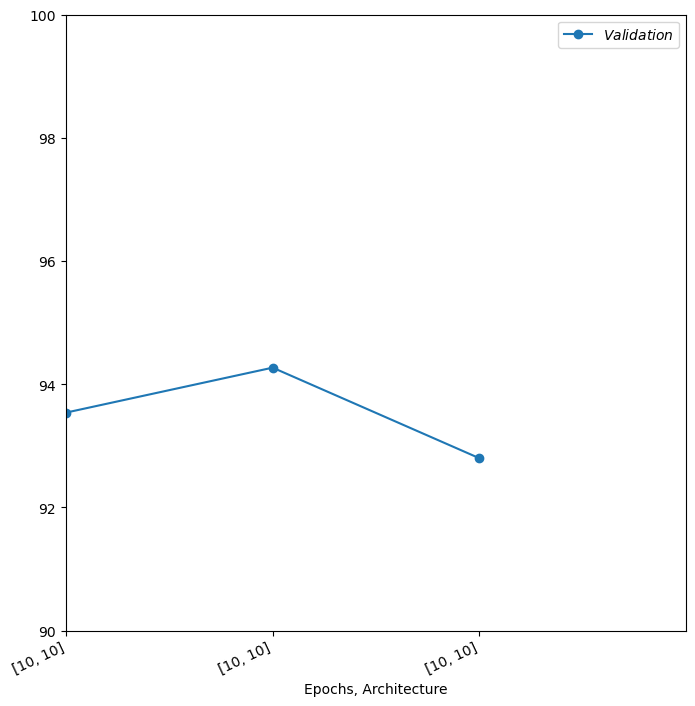

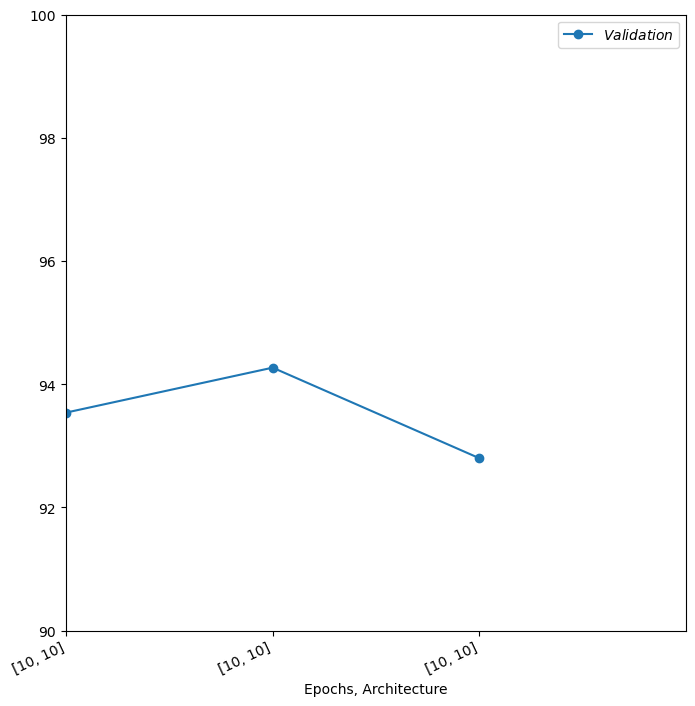

In [13]:
result_fc = run_experiment( Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices=[[10,10],[10,10],[10,10]],
                           n_hiddens_per_fc_layer_choices=[[10],[10],[10,10]],
                          patch_size_per_conv_layer_choices = [[5,5],[5,5],[5,5]],
                          stride_per_conv_layer_choices=[[1,1],[1,1],[1,1]])

In [14]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer=[1,1]
n_hiddens_per_fc_layer = [10]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 2 Loss 0.406
adam: Epoch 4 Loss 0.311
adam: Epoch 6 Loss 0.259
adam: Epoch 8 Loss 0.241
adam: Epoch 10 Loss 0.224
adam: Epoch 12 Loss 0.213
adam: Epoch 14 Loss 0.201
adam: Epoch 16 Loss 0.204
adam: Epoch 18 Loss 0.194
adam: Epoch 20 Loss 0.186


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=4000, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [15]:
class CNN1D(CNN2D):
    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer,
                                n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer,
                                stride_per_conv_layer):

        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.

        n_in = 1
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0

        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(
                torch.nn.Conv1d(n_in,
                                nh,
                                kernel_size=patch_size,
                                stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <=0:
                raise Exception(
                    f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [16]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [17]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

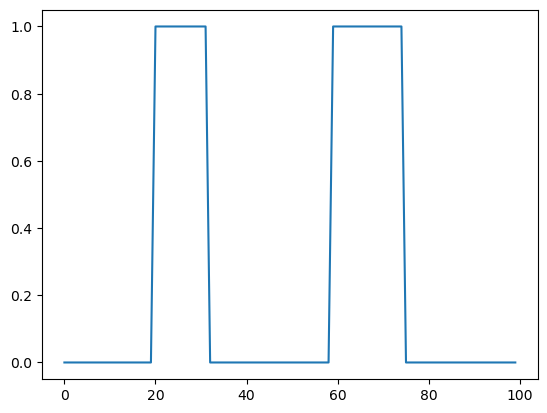

In [18]:
plt.plot(square_pulse)

In [19]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [20]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.5 , 1.  , 1.  , 0.5 , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.75, 1.  ,
       1.  , 0.75, 0.5 , 0.25, 0.  , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 1.  ,
       0.75, 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

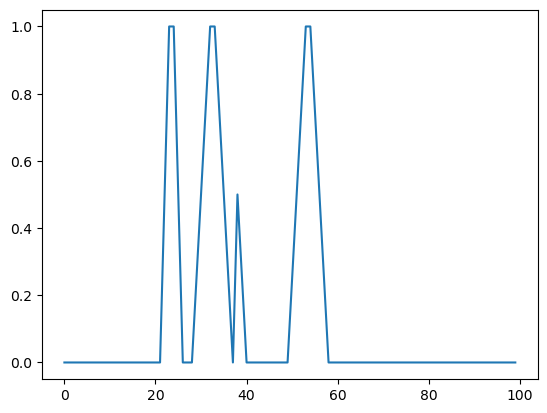

In [21]:
plt.plot(triangular_pulse)

In [22]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [23]:
np.newaxis == None

True

In [24]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [25]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.615
adam: Epoch 20 Loss 0.428
adam: Epoch 30 Loss 0.125
adam: Epoch 40 Loss 0.040
adam: Epoch 50 Loss 0.011
adam: Epoch 60 Loss 0.004
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.001
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

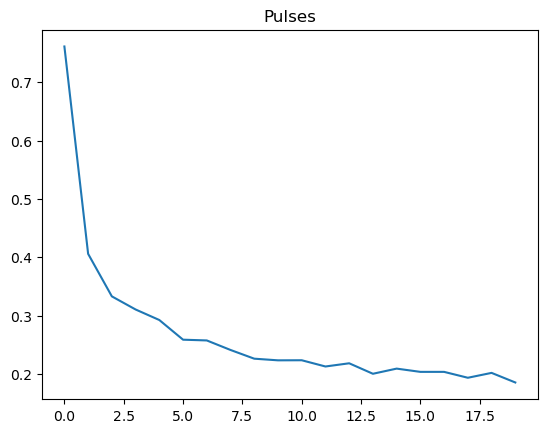

In [27]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet1.error_trace = [e.detach().numpy() for e in cnnet.error_trace]
plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [28]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.70


,square,triangular
square,99.4,0.6
triangular,0.0,100.0


torch.Size([10, 10])

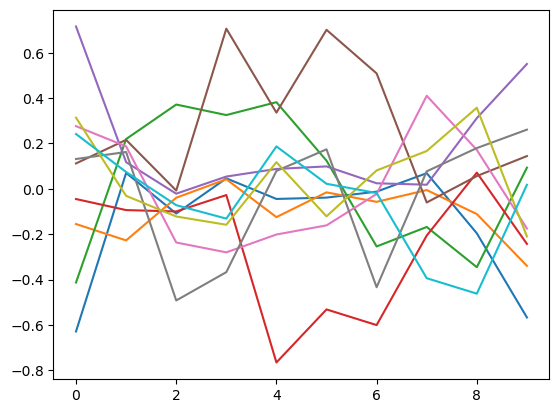

In [29]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [30]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

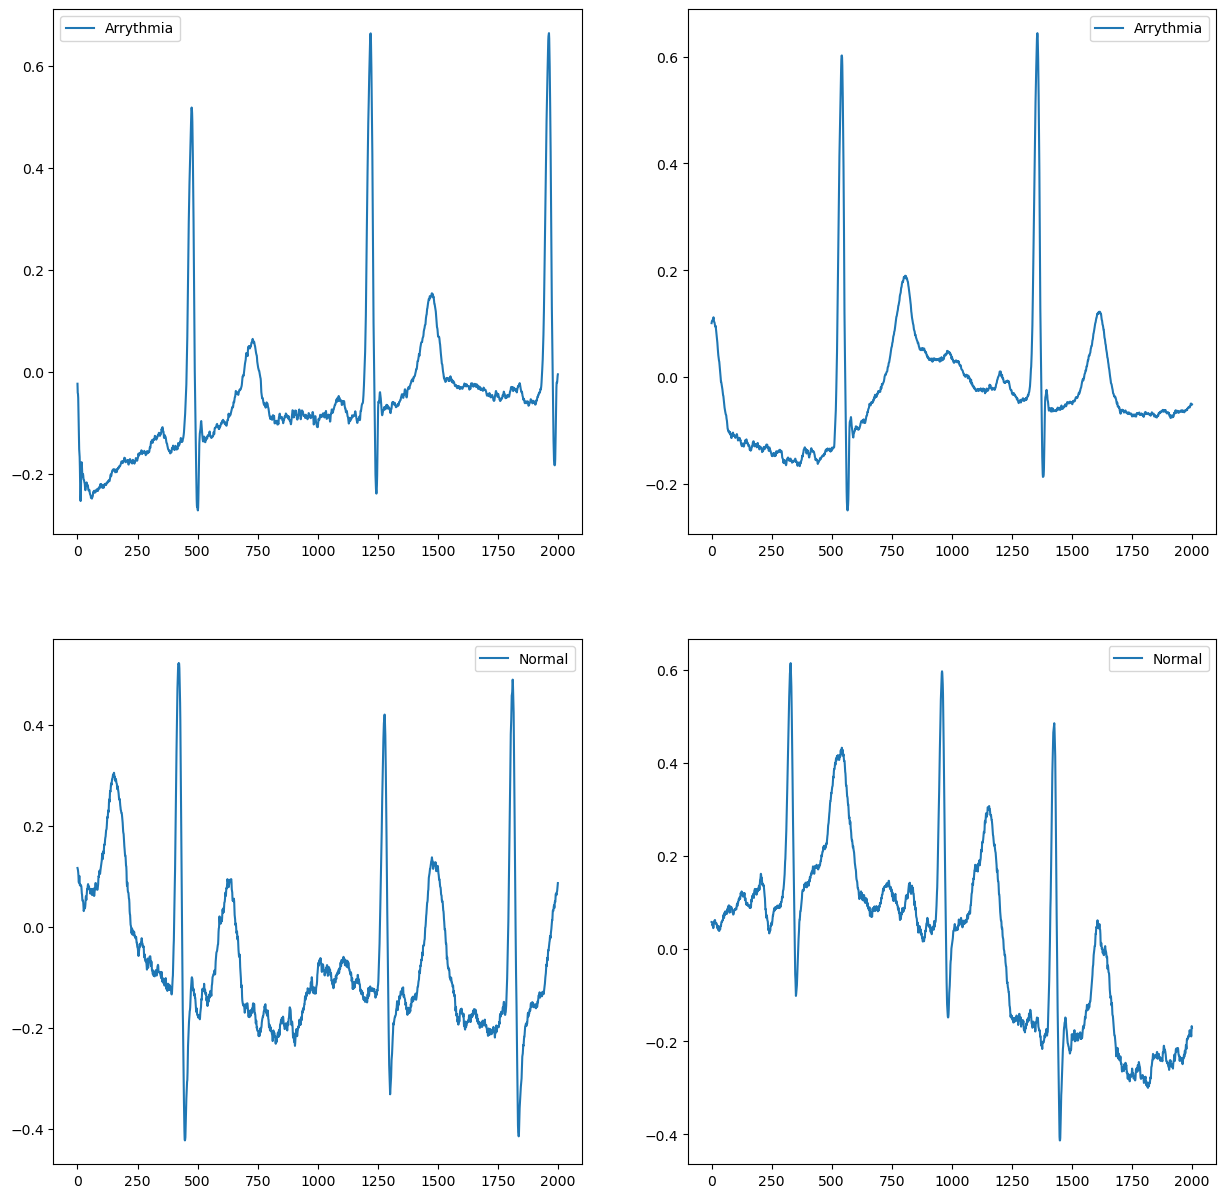

In [31]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [32]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [33]:
Ttrain

array([['arr'],
       ['arr'],
       ['arr'],
       ...,
       ['arr'],
       ['nr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [35]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)
cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 10 Loss 0.366
adam: Epoch 20 Loss 0.208
adam: Epoch 30 Loss 0.140
adam: Epoch 40 Loss 0.091
adam: Epoch 50 Loss 0.085
adam: Epoch 60 Loss 0.081
adam: Epoch 70 Loss 0.045
adam: Epoch 80 Loss 0.053
adam: Epoch 90 Loss 0.042
adam: Epoch 100 Loss 0.024


CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 5, kernel_size=(100,), stride=(20,))
    (1): Conv1d(5, 10, kernel_size=(20,), stride=(5,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=160, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [36]:
from IPython.display import display, clear_output  # for the following animation.
import matplotlib.animation as animation
from pdb import set_trace
import time

def run_experiment_1d(Xtrain, Ttrain, Xtest, Ttest,
                   n_hidden_units_per_layer_choices,patch_size_per_conv_layer_choices,stride_per_conv_layer_choices,
                   n_hiddens_per_fc_layer_choices):
    n_epochs = 100
    batch_size = 10
    learning_rate = 0.001
    results = []
    Classes = np.unique(Ttrain)
    fig = plt.figure(figsize=(8, 8))
    train_graph = []
    #     Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,n_folds)
    #         print(epoch)
    i = 0
    for i in range(len(n_hidden_units_per_layer_choices)):
        Time = []
        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))

        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], hidden_units,len(Classes))
        n_hiddens_per_conv_layer = n_hidden_units_per_layer_choices[i]
        patch_size_per_conv_layer= patch_size_per_conv_layer_choices[i]
        stride_per_conv_layer = stride_per_conv_layer_choices[i]
        n_hiddens_per_fc_layer=n_hiddens_per_fc_layer_choices[i]
#         set_trace()
# cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [10, 1], [20, 5], device=device)

        cnnet = CNN1D(Xtrain.shape[-1],
                      n_hiddens_per_conv_layer,
                      n_hiddens_per_fc_layer,
                      len(np.unique(Ttrain)),
                      patch_size_per_conv_layer,
                      stride_per_conv_layer,
                      device=device)

        start_time = time.time()

        cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


        Time_for_train = time.time() - start_time
        
        Classes, _ = cnnet.use(Xtest)
        perc_correct = 100 * np.mean(Classes == Ttest)

        C_test, Y_test = cnnet.use(Xtest)
        C_train, Y_train = cnnet.use(Xtrain)
#         C_val, Y_val = cnnet.use(Xval)

        test_p = 100 * np.mean(C_test == Ttest)
        train_p = 100 * np.mean(C_train == Ttrain)
#         val_p = 100 * np.mean(C_val == Tval)
                   
       
        train_graph.append(test_p)
        results.append([n_hiddens_per_conv_layer,
                        n_hiddens_per_fc_layer,
                        patch_size_per_conv_layer,
                        stride_per_conv_layer,
                        train_p,
                        test_p, 
                        Time_for_train])
        df = pandas.DataFrame(results,
                              columns=('nh','fc','patch','stride', 'Train', 'Test', 'Time'))
        fig.clf()

        # In second panel plot the weights versus the epoch number
        # plt.subplot(2, 2, i+1)
        # set_trace()
        xs = range(df.shape[0])
        plt.plot(xs, train_graph, 'o-')

        xticks = df[['nh','fc','patch','stride']].apply(lambda x: f'{x[0]}',
                                  axis=1)  # converting to strings
        plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
        plt.xlabel('Epochs, Architecture')
        plt.xlim(0, len(n_hidden_units_per_layer_choices))
        plt.ylim(60, 100)
        plt.legend(('$Testing$', '$w_1$'))
        clear_output(wait=True)
        display(fig)

    return df

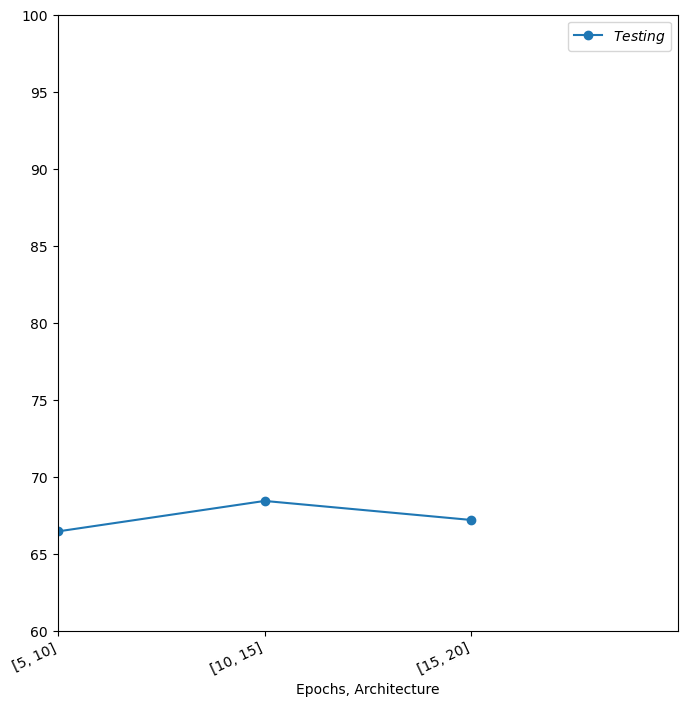

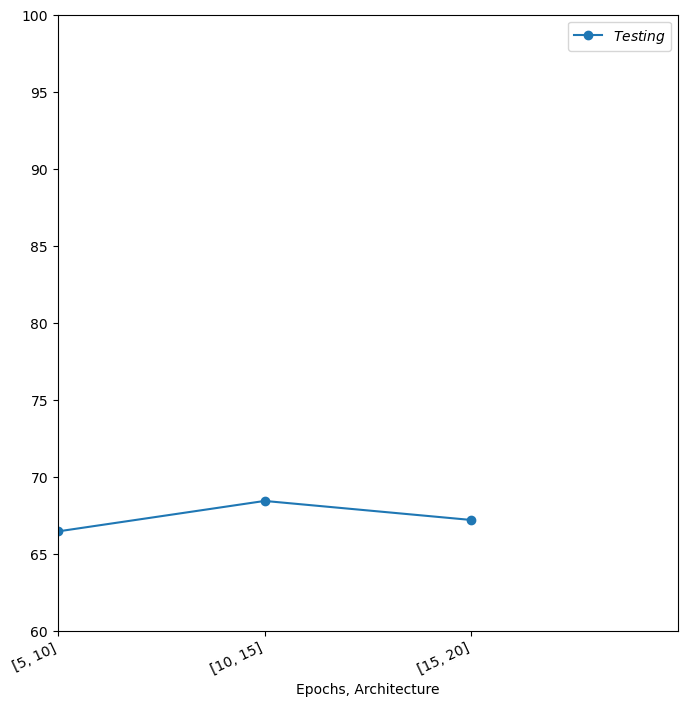

In [37]:
# cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [10, 1], [20, 5], device=device)

#         cnnet = CNN1D(Xtrain.shape[-1],
#                       n_hiddens_per_conv_layer,
#                       n_hiddens_per_fc_layer,
#                       len(np.unique(Ttrain)),
#                       patch_size_per_conv_layer,
#                       stride_per_conv_layer,
#                       device=device)
result_1d = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[10,15],[15,20]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[10,1],[10,1],[10,1]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[20,5],[20,5],[20,5]]) # [10,10],[10],[10,10]])

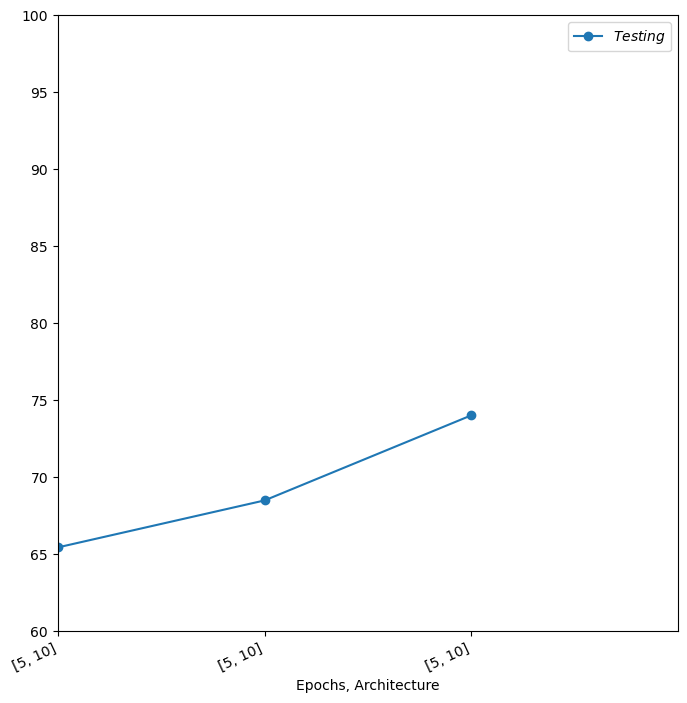

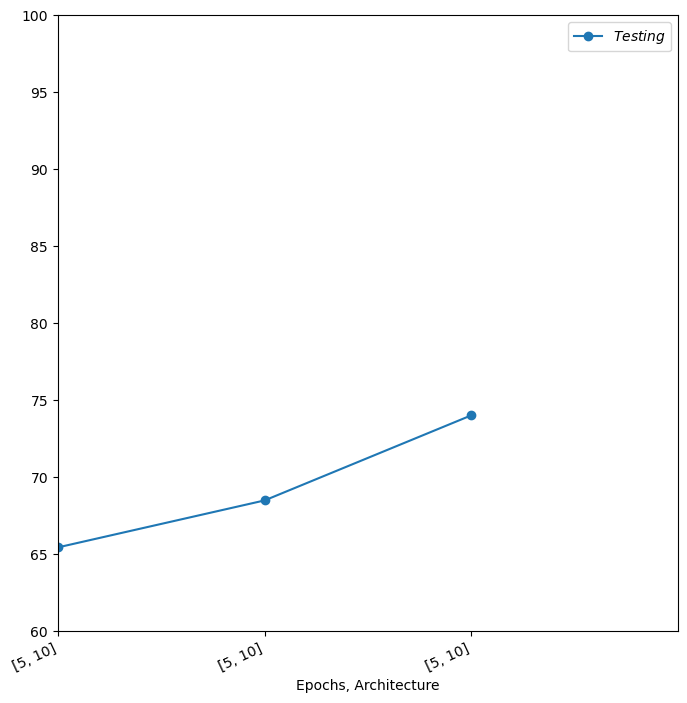

In [38]:
result_1d_1 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[20,1],[40,1],[80,1]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[20,5],[20,5],[20,5]]) # [10,10],[10],[10,10]])

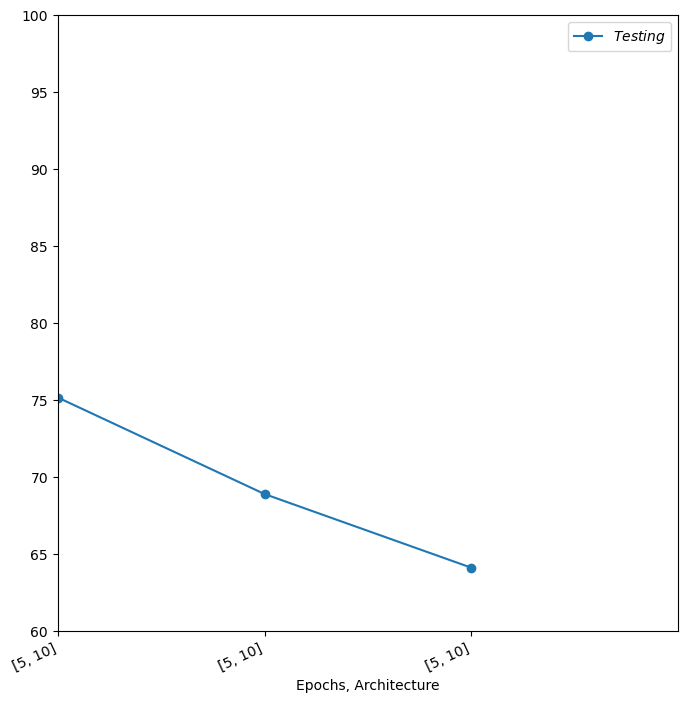

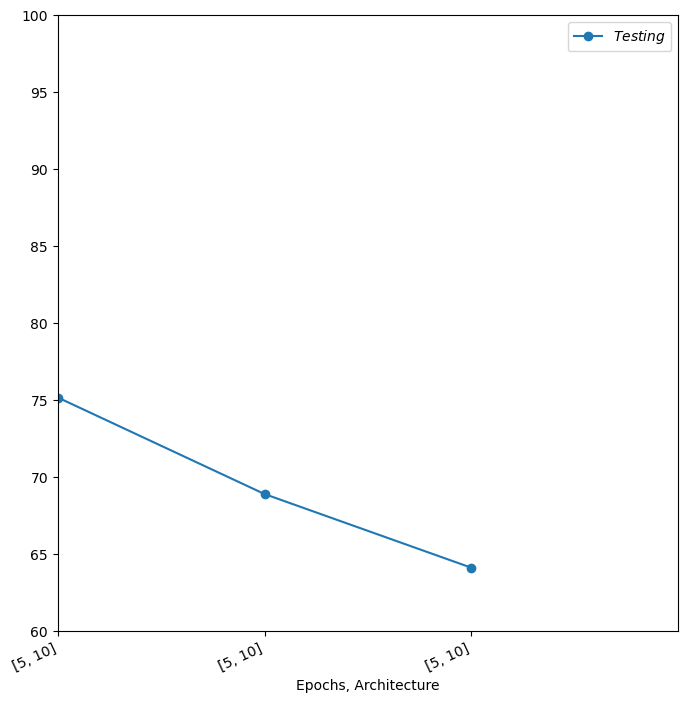

In [39]:
result_1d_2 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[80,1],[80,1],[80,1]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[10,5],[20,10],[40,20]]) # [10,10],[10],[10,10]])

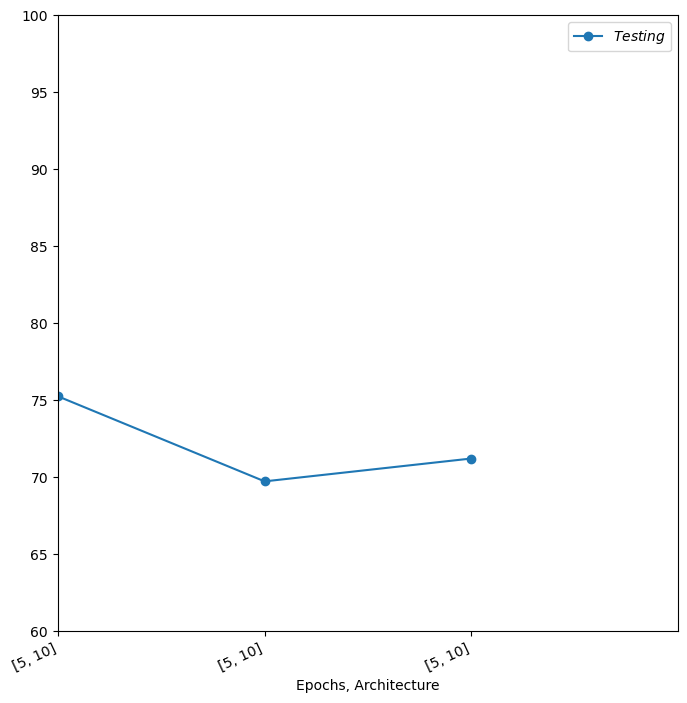

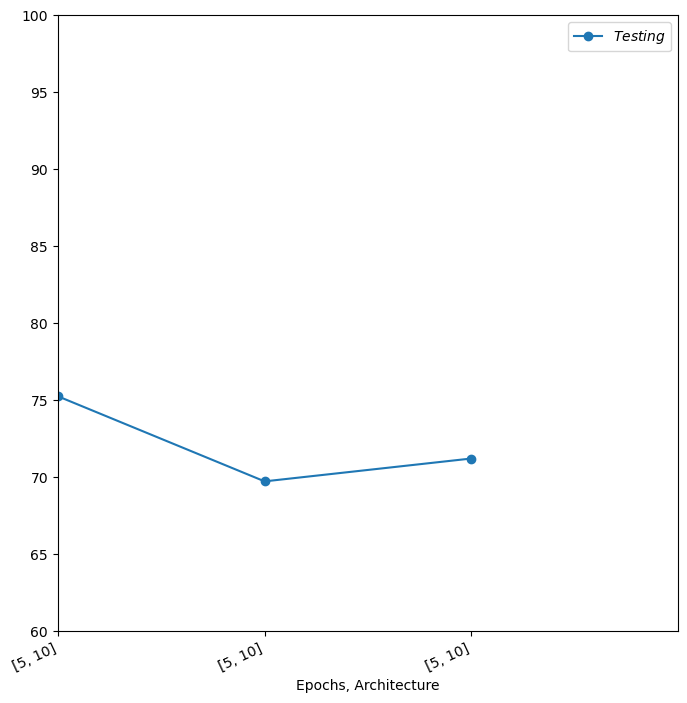

In [40]:
result_1d_3 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], 
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],
                          patch_size_per_conv_layer_choices =[[80,1],[80,1],[80,1]], 
                          stride_per_conv_layer_choices     =[[5,5],[4,4],[3,3]]) 

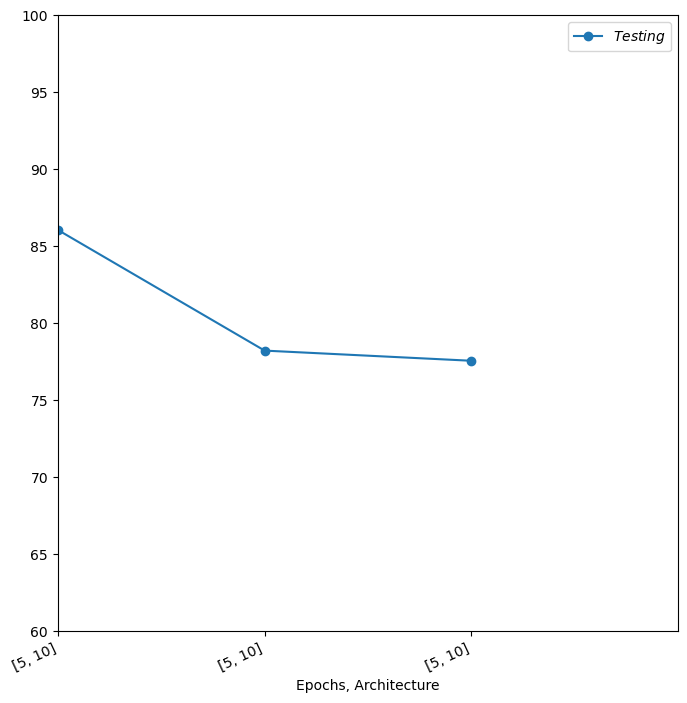

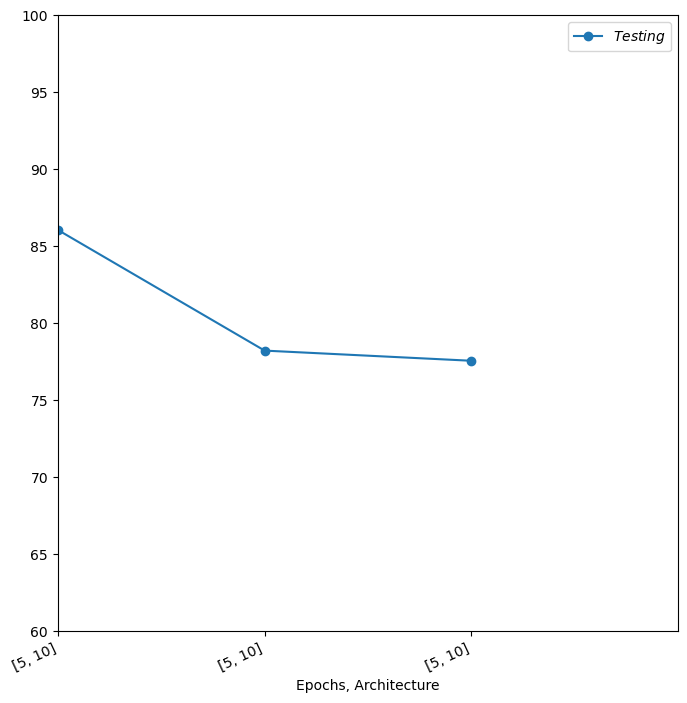

In [41]:
result_1d_4 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], 
                           n_hiddens_per_fc_layer_choices   =[[600,300],[300,150],[200,100]],
                          patch_size_per_conv_layer_choices =[[80,1],[80,1],[80,1]], 
                          stride_per_conv_layer_choices     =[[4,4],[4,4],[4,4]])

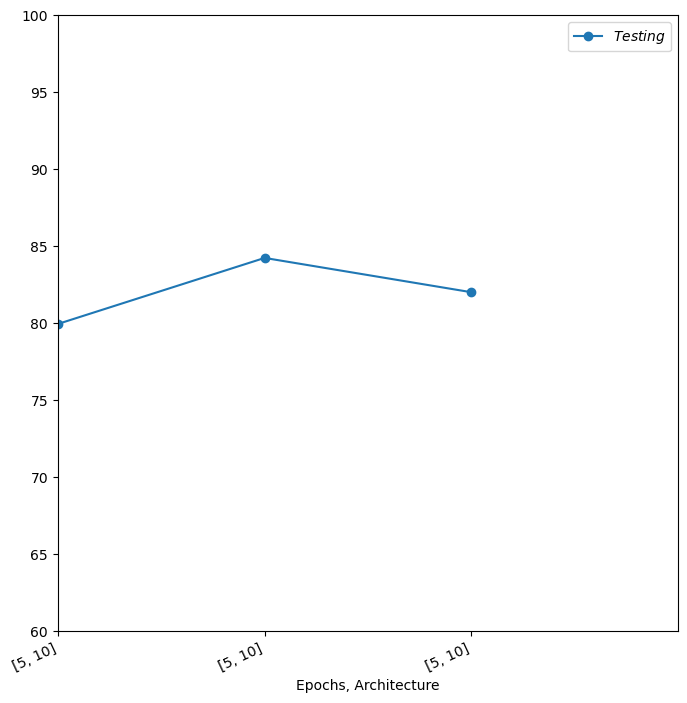

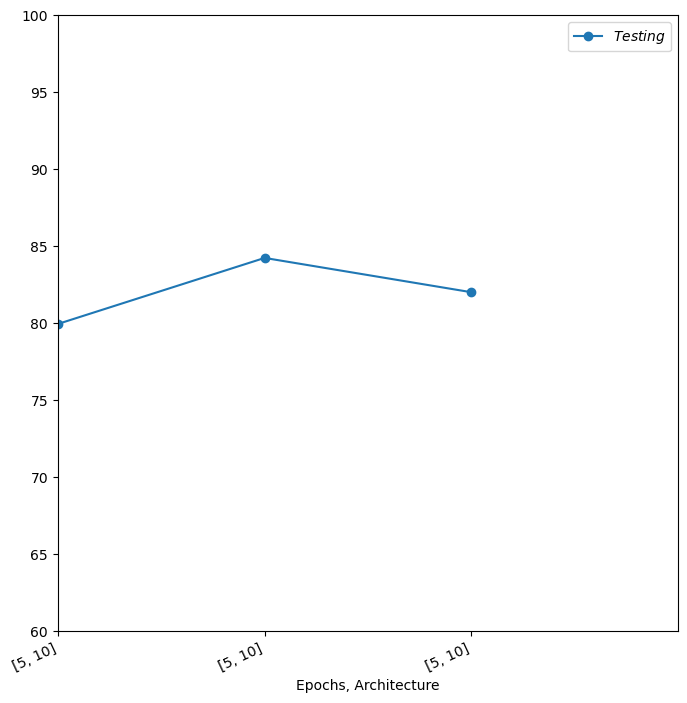

In [42]:
result_1d_5 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]],
                           n_hiddens_per_fc_layer_choices   =[[600,300],[600,300],[600,300]],
                          patch_size_per_conv_layer_choices =[[100,1],[150,1],[200,1]],
                          stride_per_conv_layer_choices     =[[4,4],[4,4],[4,4]])

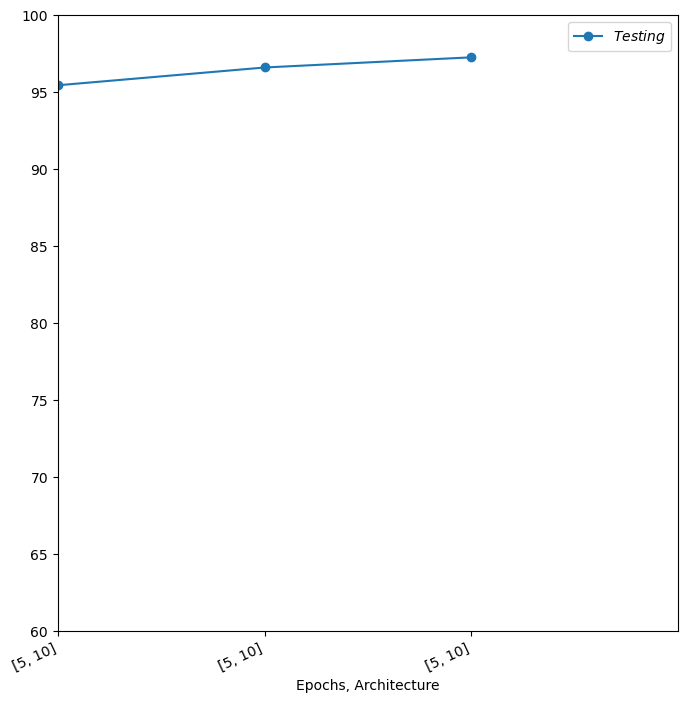

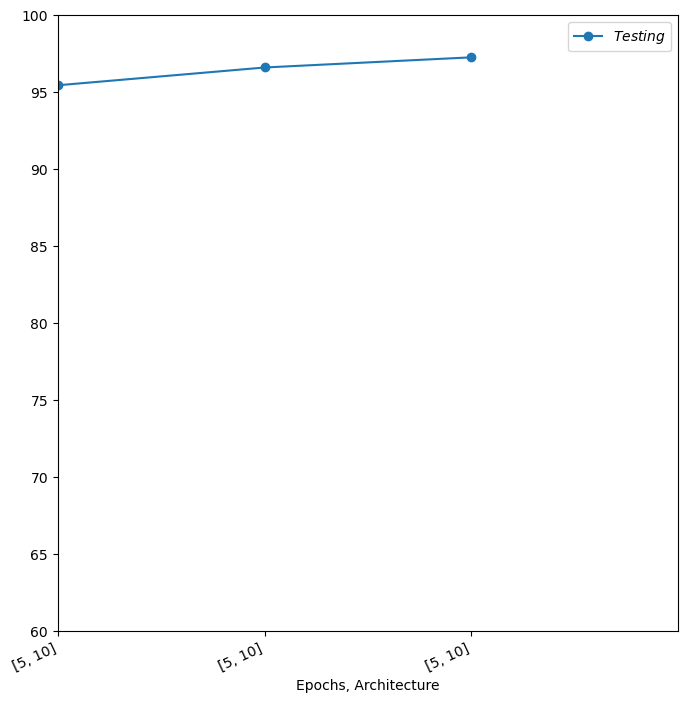

In [43]:
result_1d_6 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[600,300],[600,300],[600,300]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[150,50],[150,75],[150,100]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[4,4],[4,4],[4,4]]) # [10,10],[10],[10,10]])

In [44]:
final = pandas.DataFrame()
final = final.append(result_1d_1, ignore_index=True)
final = final.append(result_1d_2, ignore_index=True)
final = final.append(result_1d_3, ignore_index=True)
final = final.append(result_1d_4, ignore_index=True)
final = final.append(result_1d_5, ignore_index=True)
final = final.append(result_1d_6, ignore_index=True)

final

/var/folders/9b/nsfxppj52z5gfzm9402l24w80000gn/T/ipykernel_4143/232639442.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(result_1d_1, ignore_index=True)
/var/folders/9b/nsfxppj52z5gfzm9402l24w80000gn/T/ipykernel_4143/232639442.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(result_1d_2, ignore_index=True)
/var/folders/9b/nsfxppj52z5gfzm9402l24w80000gn/T/ipykernel_4143/232639442.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(result_1d_3, ignore_index=True)
/var/folders/9b/nsfxppj52z5gfzm9402l24w80000gn/T/ipykernel_4143/232639442.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,nh,fc,patch,stride,Train,Test,Time
0,"[5, 10]","[10, 10]","[20, 1]","[20, 5]",85.237113,65.457543,223.396653
1,"[5, 10]","[10, 10]","[40, 1]","[20, 5]",82.577320,68.507832,1183.978776
2,"[5, 10]","[10, 10]","[80, 1]","[20, 5]",89.402062,74.031327,224.281257
3,"[5, 10]","[10, 10]","[80, 1]","[10, 5]",94.309278,75.185491,233.995708
4,"[5, 10]","[10, 10]","[80, 1]","[20, 10]",81.278351,68.920033,223.061068
5,"[5, 10]","[10, 10]","[80, 1]","[40, 20]",69.030928,64.138500,219.857992
6,"[5, 10]","[10, 10]","[80, 1]","[5, 5]",97.628866,75.267931,1625.601200
7,"[5, 10]","[10, 10]","[80, 1]","[4, 4]",93.092784,69.744435,2267.151842
8,"[5, 10]","[10, 10]","[80, 1]","[3, 3]",97.360825,71.228359,862.102910
9,"[5, 10]","[600, 300]","[80, 1]","[4, 4]",100.000000,86.067601,1492.056255


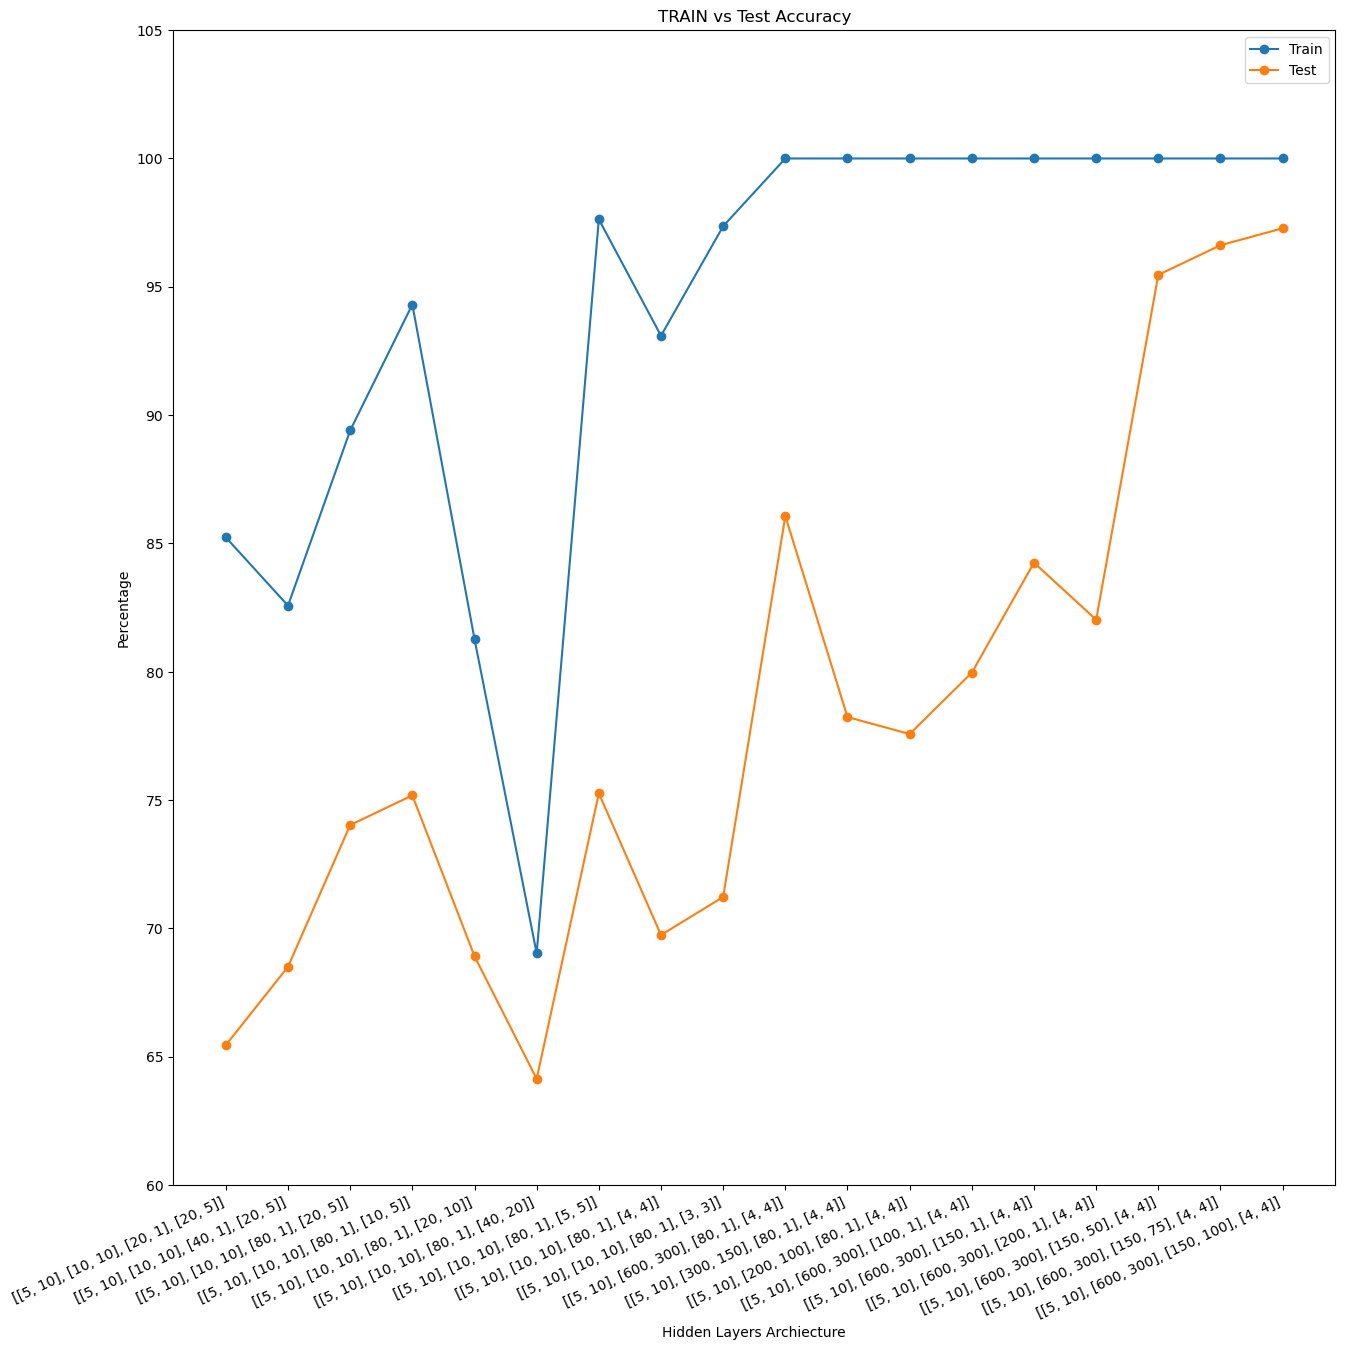

In [45]:
X_axis = final.loc[:, 'Train']
X_axis1 = final.loc[:, 'Test']
plt.figure(figsize=(15, 15))
plt.plot(X_axis, 'o-', label='Train')
plt.plot(X_axis1, 'o-', label='Test')
xticks = final[['nh','fc','patch','stride']].apply(lambda x: f'{[x[0]] + [x[1]] + [x[2]] +[x[3]]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.ylim(60, 105)
plt.xlabel('Hidden Layers Archiecture')
plt.ylabel('Percentage');
plt.title('TRAIN vs Test Accuracy')
plt.legend()

In [46]:
final.to_pickle("./data.pkl")

In [49]:
n_epochs = 100
batch_size = 10
learning_rate = 0.001
cnn1d_best = CNN1D(Xtrain.shape[-1], [5, 10], [600, 300], 2, [150, 100], [4, 4], device=device)
cnn1d_best.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 10 Loss 0.142
adam: Epoch 20 Loss 0.063
adam: Epoch 30 Loss 0.014
adam: Epoch 40 Loss 0.000
adam: Epoch 50 Loss 0.000
adam: Epoch 60 Loss 0.000
adam: Epoch 70 Loss 0.000
adam: Epoch 80 Loss 0.000
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 5, kernel_size=(150,), stride=(4,))
    (1): Conv1d(5, 10, kernel_size=(100,), stride=(4,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=910, out_features=600, bias=True)
    (1): Linear(in_features=600, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=2, bias=True)
  )
)

In [50]:
Classes, _ = cnn1d_best.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 96.37


,arr,nr
arr,94.618834,5.381166
nr,2.607562,97.392438


<h3>Observations

Initially, I experimented with increasing the patch sizes, which led to an improvement in the model's performance. However, the model was unable to surpass 90% training accuracy and only achieved 72% accuracy on the testing data. The optimal patch size was found to be [80,1]. Next, I gradually increased the stride values and noticed a significant decline in the model's accuracy. This indicated that larger strides caused the model to skip more data during training, adversely affecting its performance. As a result, I attempted to reduce the stride values in subsequent iterations, which led to an enhancement in the model's performance. The best combination was determined to be a patch size of [80,1] and a stride of [4,4].

With the patch size and stride values held constant, I increased the number of fully connected layers and observed an improvement in the model's performance. The model achieved 100% accuracy on the training data but was still unable to reach 80% accuracy on the testing data. The optimal configuration for the fully connected layers was found to be [600, 300]. Keeping this constant, I significantly increased the patch sizes again and observed that the model performed better on the training data, reaching an accuracy of 97.60% with the following configuration:

Hidden Layers = [5, 10]
Fully Connected Layers = [600, 300]
Patch Size = [150, 100]
Stride = [4, 4]

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [137]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'karra-A5.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook karra-A5.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.use(Xtrain)[0] == Ttrain)
    perc_test = 100 * np.mean(cnn1d.use(Xtest)[0] == Ttest)

adam: Epoch 2 Loss 0.009
adam: Epoch 4 Loss 0.003
adam: Epoch 6 Loss 0

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.

In [52]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Xval = Xval.reshape(-1, 1, 28, 28)

<h3>1 Tanh vs Relu

In [53]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]
n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet_tanh = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh',device=device)




cnnet_relu = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='relu',device=device)



cnnet_tanh.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet_relu.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 2 Loss 0.419
adam: Epoch 4 Loss 0.272
adam: Epoch 6 Loss 0.230
adam: Epoch 8 Loss 0.213
adam: Epoch 10 Loss 0.201
adam: Epoch 12 Loss 0.185
adam: Epoch 14 Loss 0.175
adam: Epoch 16 Loss 0.168
adam: Epoch 18 Loss 0.165
adam: Epoch 20 Loss 0.157
adam: Epoch 2 Loss 0.234
adam: Epoch 4 Loss 0.133
adam: Epoch 6 Loss 0.106
adam: Epoch 8 Loss 0.094
adam: Epoch 10 Loss 0.085
adam: Epoch 12 Loss 0.078
adam: Epoch 14 Loss 0.073
adam: Epoch 16 Loss 0.070
adam: Epoch 18 Loss 0.063
adam: Epoch 20 Loss 0.062


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(10, 10), stride=(4, 4))
    (1): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

Text(0.5, 1.0, 'Error Trace MNIST - Relu')

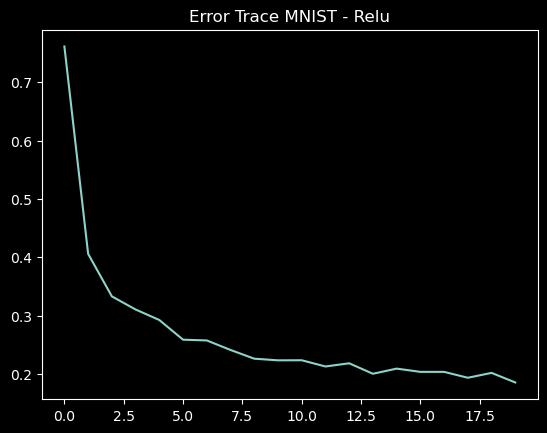

In [133]:
cnnet_relu.error_trace = [e.detach().numpy() for e in cnnet.error_trace]
plt.plot(cnnet_relu.error_trace, label='Relu')
plt.title('Error Trace MNIST - Relu')
#plt.legend(loc='best') 

Text(0.5, 1.0, 'MNIST - Tanh')

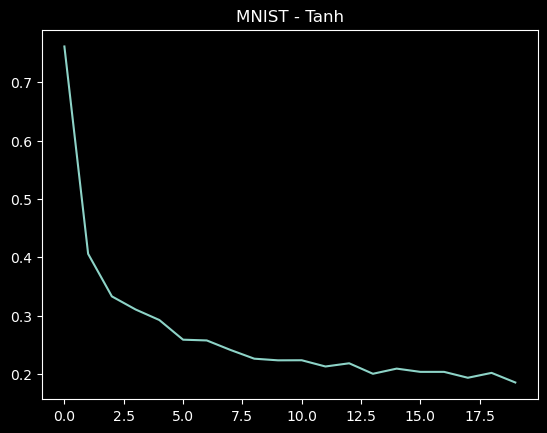

In [134]:
cnnet_tanh.error_trace = [e.detach().numpy() for e in cnnet.error_trace]
plt.plot(cnnet_tanh.error_trace, label='Tanh')
plt.title('MNIST - Tanh')


In [116]:
Classes, _ = cnnet_tanh.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct with Tanh Activation function: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")

Test accuracy in percent correct with Tanh Activation function: 83.45


,0,1,2,3,4,5,6,7,8,9
0,89.7 %,0.1 %,0.4 %,0.0 %,0.7 %,1.2 %,4.9 %,0.9 %,1.2 %,0.8 %
1,0.1 %,85.0 %,1.5 %,0.4 %,2.1 %,0.1 %,0.3 %,3.1 %,6.2 %,1.2 %
2,0.7 %,1.6 %,87.4 %,3.6 %,1.5 %,0.4 %,0.7 %,0.1 %,3.9 %,0.3 %
3,0.1 %,0.1 %,3.5 %,87.1 %,0.3 %,1.5 %,0.1 %,1.1 %,5.1 %,1.1 %
4,0.2 %,0.2 %,0.4 %,0.1 %,86.8 %,0.1 %,0.9 %,0.5 %,0.7 %,10.1 %
5,2.6 %,0.1 %,1.1 %,11.5 %,0.9 %,66.3 %,1.3 %,1.2 %,7.0 %,8.0 %
6,2.5 %,0.0 %,4.2 %,0.1 %,4.5 %,3.7 %,84.4 %,0.1 %,0.5 %,0.0 %
7,0.0 %,4.2 %,1.9 %,1.9 %,1.8 %,0.5 %,0.1 %,74.7 %,5.6 %,9.2 %
8,1.0 %,0.4 %,1.1 %,1.4 %,0.9 %,1.0 %,0.3 %,0.3 %,89.8 %,3.6 %
9,0.2 %,0.1 %,0.0 %,0.2 %,12.2 %,1.6 %,0.3 %,2.0 %,1.8 %,81.7 %


In [117]:
Classes, _ = cnnet_relu.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct with Relu Acttivation function : {perc_correct:.2f}')
confusion_matrix(Classes, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")

Test accuracy in percent correct with Relu Acttivation function : 94.94


,0,1,2,3,4,5,6,7,8,9
0,97.3 %,0.0 %,0.1 %,0.0 %,0.1 %,0.0 %,1.4 %,0.1 %,0.6 %,0.3 %
1,0.0 %,98.6 %,0.4 %,0.5 %,0.3 %,0.0 %,0.0 %,0.0 %,0.2 %,0.0 %
2,0.4 %,0.8 %,95.1 %,1.7 %,0.4 %,0.0 %,0.2 %,0.5 %,0.8 %,0.2 %
3,0.1 %,0.0 %,0.7 %,97.5 %,0.1 %,0.6 %,0.0 %,0.2 %,0.8 %,0.0 %
4,0.0 %,0.6 %,0.2 %,0.0 %,96.8 %,0.1 %,0.3 %,0.3 %,0.3 %,1.3 %
5,0.1 %,0.0 %,0.1 %,4.0 %,0.0 %,89.0 %,1.5 %,0.1 %,4.5 %,0.7 %
6,0.8 %,0.8 %,0.1 %,0.1 %,1.1 %,0.1 %,96.8 %,0.0 %,0.1 %,0.0 %
7,0.2 %,0.5 %,2.5 %,0.9 %,1.2 %,0.1 %,0.0 %,92.8 %,0.1 %,1.8 %
8,1.1 %,1.1 %,1.0 %,1.5 %,0.3 %,0.2 %,0.6 %,0.4 %,92.8 %,0.8 %
9,0.3 %,0.7 %,0.2 %,1.4 %,3.3 %,0.5 %,0.2 %,0.8 %,1.0 %,91.7 %


<h4>Observations

A comparison between the Tanh and ReLU activation functions revealed that ReLU performed better overall. The model utilizing ReLU achieved a testing accuracy of 94.94%. Additionally, the error trace demonstrated that ReLU reached its minimum value more rapidly than Tanh, indicating that the model trained faster with ReLU than with Tanh.

An examination of the confusion matrix also showed that the ReLU activation function was superior in predicting numbers compared to Tanh. Furthermore, the model with ReLU activation was more effective in minimizing false positives. For example, when using the Tanh activation function, the number 9 was mispredicted as 7 in 2.5% of cases, while the ReLU activation function resulted in only 1.2% mispredictions for the same scenario.

<h3>2 ADAM vs SGD

In [124]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]
n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet_adam = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh',device=device)




cnnet_sgd = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh',device=device)



cnnet_adam.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet_sgd.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='sgd')

adam: Epoch 2 Loss 0.377
adam: Epoch 4 Loss 0.272
adam: Epoch 6 Loss 0.238
adam: Epoch 8 Loss 0.225
adam: Epoch 10 Loss 0.205
adam: Epoch 12 Loss 0.194
adam: Epoch 14 Loss 0.193
adam: Epoch 16 Loss 0.182
adam: Epoch 18 Loss 0.176
adam: Epoch 20 Loss 0.177
sgd: Epoch 2 Loss 1.280
sgd: Epoch 4 Loss 0.654
sgd: Epoch 6 Loss 0.432
sgd: Epoch 8 Loss 0.326
sgd: Epoch 10 Loss 0.264
sgd: Epoch 12 Loss 0.222
sgd: Epoch 14 Loss 0.194
sgd: Epoch 16 Loss 0.174
sgd: Epoch 18 Loss 0.158
sgd: Epoch 20 Loss 0.147


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(10, 10), stride=(4, 4))
    (1): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

Text(0.5, 1.0, 'MNIST - adam - sgd')

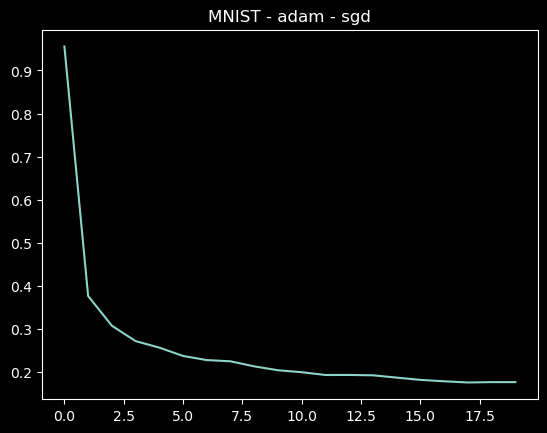

In [125]:

cnnet_adam.error_trace = [e.detach().numpy() for e in cnnet_adam.error_trace]
plt.plot(cnnet_adam.error_trace, label='Adam')
plt.title('MNIST - adam - sgd')


 

Text(0.5, 1.0, 'Error Trace - adam - sgd')

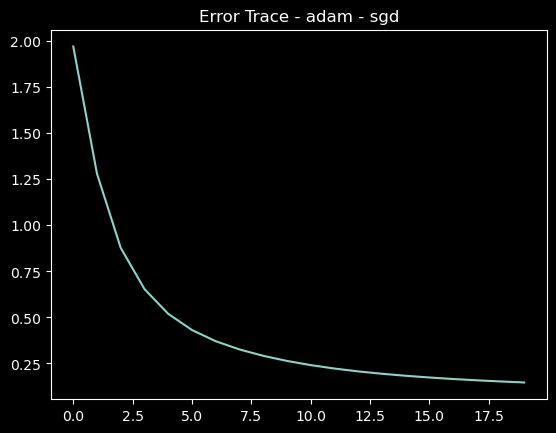

In [126]:

cnnet_sgd.error_trace = [e.detach().numpy() for e in cnnet_sgd.error_trace]
plt.plot(cnnet_sgd.error_trace, label='SGD')
plt.title('Error Trace - adam - sgd')

In [127]:
Classes, _ = cnnet_adam.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for adam: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")

Test accuracy in percent correct for adam: 94.19


,0,1,2,3,4,5,6,7,8,9
0,98.0 %,0.0 %,0.3 %,0.0 %,0.1 %,0.6 %,0.4 %,0.5 %,0.0 %,0.1 %
1,0.0 %,97.9 %,0.0 %,0.4 %,0.4 %,0.2 %,0.2 %,0.0 %,0.8 %,0.2 %
2,1.6 %,0.1 %,91.5 %,1.2 %,0.4 %,0.2 %,0.9 %,2.5 %,1.4 %,0.4 %
3,0.0 %,0.4 %,1.5 %,92.1 %,0.0 %,2.7 %,0.0 %,2.0 %,0.9 %,0.5 %
4,0.4 %,0.3 %,0.0 %,0.0 %,96.5 %,0.1 %,0.7 %,0.2 %,0.0 %,1.7 %
5,1.2 %,0.9 %,0.0 %,2.0 %,0.6 %,92.6 %,0.9 %,0.2 %,1.5 %,0.1 %
6,1.1 %,0.2 %,0.5 %,0.0 %,1.1 %,1.9 %,94.8 %,0.0 %,0.3 %,0.0 %
7,0.6 %,1.6 %,0.7 %,0.3 %,0.8 %,0.0 %,0.0 %,95.0 %,0.1 %,1.0 %
8,0.3 %,0.4 %,2.3 %,0.8 %,1.2 %,2.3 %,0.5 %,0.5 %,91.4 %,0.3 %
9,0.4 %,0.5 %,0.2 %,0.5 %,3.7 %,0.4 %,0.1 %,2.0 %,0.6 %,91.7 %


In [128]:
Classes1, _ = cnnet_sgd.use(Xtest)
perc_correct = 100 * np.mean(Classes1 == Ttest)
print(f'Test accuracy in percent correct for sgd: {perc_correct:.2f}')
confusion_matrix(Classes1, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")

Test accuracy in percent correct for sgd: 95.61


,0,1,2,3,4,5,6,7,8,9
0,97.9 %,0.0 %,0.0 %,0.0 %,0.1 %,0.2 %,0.6 %,0.4 %,0.7 %,0.1 %
1,0.0 %,98.0 %,0.8 %,0.2 %,0.0 %,0.0 %,0.4 %,0.4 %,0.2 %,0.0 %
2,0.3 %,0.3 %,94.6 %,1.2 %,0.1 %,0.2 %,0.6 %,0.8 %,1.9 %,0.1 %
3,0.0 %,0.1 %,1.0 %,94.5 %,0.0 %,1.1 %,0.0 %,0.7 %,1.9 %,0.8 %
4,0.0 %,0.2 %,0.4 %,0.0 %,96.9 %,0.3 %,0.7 %,0.0 %,0.0 %,1.4 %
5,0.6 %,0.3 %,0.0 %,1.5 %,0.2 %,94.6 %,0.7 %,0.1 %,1.5 %,0.6 %
6,1.0 %,0.4 %,0.6 %,0.0 %,0.5 %,1.1 %,95.8 %,0.0 %,0.4 %,0.0 %
7,0.3 %,0.4 %,1.2 %,0.3 %,0.3 %,0.0 %,0.0 %,96.1 %,0.5 %,1.0 %
8,0.4 %,0.2 %,1.1 %,0.5 %,0.3 %,0.9 %,0.6 %,0.9 %,94.6 %,0.4 %
9,0.3 %,0.3 %,0.1 %,0.6 %,1.5 %,1.4 %,0.1 %,2.5 %,0.4 %,92.9 %


It is evident from the error trace that the Adam optimization algorithm surpassed the performance of SGD (Stochastic Gradient Descent) by reaching a lower error value more quickly. This indicates that the model trained faster when using the Adam method. While both optimization methods eventually reached similar error values, Adam achieved this result at a faster rate.

In terms of testing accuracy, there is no substantial difference between the Adam and SGD methods. However, the Adam method achieved a testing accuracy of 94.19%, while SGD reached a slightly higher training accuracy of 95.61%. Despite this minor discrepancy, both methods demonstrate strong performance in this context.


